## 問題

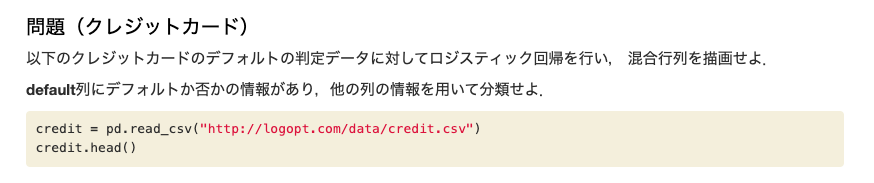

In [1]:
from IPython.display import Image
Image('credit-card-default.png')

## 解答

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
credit = pd.read_csv('http://logopt.com/data/credit.csv')
credit.head()

,limit,sex,edu,married,age,apr_delay,may_delay,jun_delay,jul_delay,aug_delay,...,jul_bill,aug_bill,sep_bill,apr_pay,may_pay,jun_pay,jul_pay,aug_pay,sep_pay,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
credit.shape

(30000, 24)

In [5]:
credit.columns

Index(['limit', 'sex', 'edu', 'married', 'age', 'apr_delay', 'may_delay',
       'jun_delay', 'jul_delay', 'aug_delay', 'sep_delay', 'apr_bill',
       'may_bill', 'jun_bill', 'jul_bill', 'aug_bill', 'sep_bill', 'apr_pay',
       'may_pay', 'jun_pay', 'jul_pay', 'aug_pay', 'sep_pay', 'default'],
      dtype='object')

In [6]:
pd.DataFrame(credit.dtypes).transpose()

,limit,sex,edu,married,age,apr_delay,may_delay,jun_delay,jul_delay,aug_delay,...,jul_bill,aug_bill,sep_bill,apr_pay,may_pay,jun_pay,jul_pay,aug_pay,sep_pay,default
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [7]:
credit.dtypes.unique()

array([dtype('int64')], dtype=object)

In [8]:
X = credit.drop('default', axis=1)
y = credit['default']

In [9]:
print(
    'Num of defauls: {}\n'.format(y.sum()),
    'Num of rows: {}\n'.format(len(y)),
    'Rate: {}'.format(y.sum() / len(y)),
    sep=''
)

Num of defauls: 6636
Num of rows: 30000
Rate: 0.2212


### EDA

In [10]:
sorted(credit['sex'].unique())

[1, 2]

In [11]:
sorted(credit['edu'].unique())

[0, 1, 2, 3, 4, 5, 6]

In [12]:
sorted(credit['married'].unique())

[0, 1, 2, 3]

In [13]:
sorted(credit['apr_delay'].unique())

[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [14]:
credit['apr_bill'].unique()[:10]

array([  3913,   2682,  29239,  46990,   8617,  64400, 367965,  11876,
        11285,      0])

In [15]:
credit['apr_pay'].unique()[:10]

array([    0,  1518,  2000,  2500, 55000,   380,  3329,  2306, 21818,
        1000])

In [16]:
print(
    'Categorical features:',
    ['sex', 'married']
)

Categorical features: ['sex', 'married']


### ロジスティック回帰

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [18]:
# The below does not work.
# This is bacause in the transform method X[self.cols] transforms the original X.

# class StandardScalerCustom(BaseEstimator, TransformerMixin):
#     def __init__(self, cols):
#         self.cols = cols
#         self.sc = StandardScaler()
    
#     def fit(self, X, y=None):
#         self.sc.fit(X[self.cols])
#         return self
    
#     def transform(self, X, y=None):
#         print(X[self.cols].head())
#         X[self.cols] = self.sc.transform(X[self.cols])
#         print(X[self.cols].head())
#         return X

In [19]:
class StandardScalerCustom(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.sc = StandardScaler()
    
    def fit(self, X, y=None):
        self.sc.fit(X[self.cols])
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy[self.cols] = self.sc.transform(X_copy[self.cols])
        return X_copy

In [20]:
class OneHotEncoderCustom(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.get_dummies(X, columns=self.cols, drop_first=True)
        return X

In [21]:
# df_test = pd.DataFrame([[-1], [0], [1]], columns=['test'])
# print(df_test)

# sc = StandardScalerCustom(['test'])
# sc.fit(df_test)
# sc.transform(df_test)

In [22]:
# df_test = pd.DataFrame([[-1], [0], [1]], columns=['test'])
# print(df_test)

# sc = OneHotEncoderCustom(['test'])
# sc.fit(df_test)
# sc.transform(df_test)

In [23]:
months = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
cols_scaling = (
    [f'{month}_delay' for month in months]
    + [f'{month}_bill' for month in months]
    + [f'{month}_pay' for month in months]
)
cols_ohe = ['sex', 'married']

In [24]:
pipe = make_pipeline(
    StandardScalerCustom(cols_scaling),
    OneHotEncoderCustom(cols_ohe),
    LogisticRegression(random_state=1, max_iter=1000, class_weight={1: 4.65})
)

In [25]:
pipe.fit(X, y)

Pipeline(steps=[('standardscalercustom',
                 StandardScalerCustom(cols=['apr_delay', 'may_delay',
                                            'jun_delay', 'jul_delay',
                                            'aug_delay', 'sep_delay',
                                            'apr_bill', 'may_bill', 'jun_bill',
                                            'jul_bill', 'aug_bill', 'sep_bill',
                                            'apr_pay', 'may_pay', 'jun_pay',
                                            'jul_pay', 'aug_pay', 'sep_pay'])),
                ('onehotencodercustom',
                 OneHotEncoderCustom(cols=['sex', 'married'])),
                ('logisticregression',
                 LogisticRegression(class_weight={1: 4.65}, max_iter=1000,
                                    random_state=1))])

In [26]:
pipe.score(X, y)

0.4997

In [27]:
y_pred = pipe.predict(X)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [28]:
y_pred.sum()

18449

#### 混合行列

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
cm = confusion_matrix(y, y_pred)
cm

array([[ 9953, 13411],
       [ 1598,  5038]])

In [31]:
tn, fp, fn, tp = cm.ravel()

In [32]:
print(
    f'true negative: {tn}',
    f'false positive: {fp}',
    f'false negative: {fn}',
    f'true positive: {tp}',
    sep='\n'
)

true negative: 9953
false positive: 13411
false negative: 1598
true positive: 5038


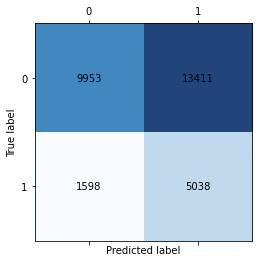

In [33]:
_, ax = plt.subplots()
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.9)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i,j], va='center', ha='center')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

#### 評価尺度

In [34]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [35]:
print('Accuracy score:', accuracy_score(y, y_pred))
print('Precision score:', np.around(precision_score(y, y_pred), 4))
print('Recall score:', np.around(recall_score(y, y_pred), 4))
print('F1 score:', np.around(f1_score(y, y_pred), 4))

Accuracy score: 0.4997
Precision score: 0.2731
Recall score: 0.7592
F1 score: 0.4017


In [36]:
cm

array([[ 9953, 13411],
       [ 1598,  5038]])

In [37]:
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 / ((1/precision) + (1/recall))

print('Accuracy score:', np.around(accuracy, 4))
print('Precision score:', np.around(precision, 4))
print('Recall score:', np.around(recall, 4))
print('F1 score:', np.around(f1, 4))

Accuracy score: 0.4997
Precision score: 0.2731
Recall score: 0.7592
F1 score: 0.4017


In [38]:
tpr = tp / (tp + fn)  # true positive rate
fpr = fp / (tn + fp)  # false positive rate

print('True positive rate:', np.around(tpr, 4))
print('False positive rate:', np.around(fpr, 4))

True positive rate: 0.7592
False positive rate: 0.574


#### 閾値変化図

In [39]:
def get_evaluation_metrics(y_true, y_pred_prob, threshold):
    y_pred = np.where(y_pred_prob >= threshold, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1

In [40]:
y_pred_prob = pipe.predict_proba(X)[:, 1]
y_pred_prob

array([0.58459658, 0.58553037, 0.58230226, ..., 0.79686268, 0.57048021,
       0.64654409])

In [41]:
thresholds = np.arange(0, 1, 0.01)
accs = []
pres = []
recs = []
f1s = []

for threshold in thresholds:
    acc, pre, rec, f1 = get_evaluation_metrics(y, y_pred_prob, threshold)
    accs.append(acc)
    pres.append(pre)
    recs.append(rec)
    f1s.append(f1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


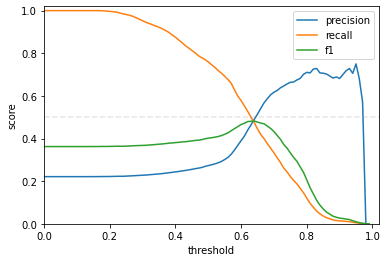

In [42]:
_, ax = plt.subplots(nrows=1, ncols=1)
# ax.plot(thresholds, accs, label='accuracy')
ax.plot(thresholds, pres, label='precision')
ax.plot(thresholds, recs, label='recall')
ax.plot(thresholds, f1s, label='f1')
ax.legend()
ax.set_xlim([0, 1.02])
ax.set_ylim([0, 1.02])
ax.set_xlabel('threshold')
ax.set_ylabel('score')
ax.axhline(0.5, color='gray', alpha=0.2, linestyle='--')
plt.show()

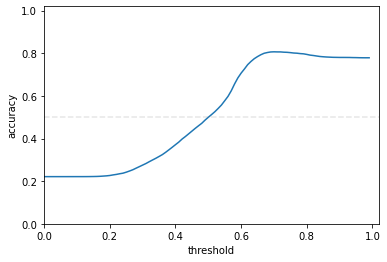

In [43]:
_, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(thresholds, accs)
ax.set_xlim([0, 1.02])
ax.set_ylim([0, 1.02])
ax.set_xlabel('threshold')
ax.set_ylabel('accuracy')
ax.axhline(0.5, color='gray', alpha=0.2, linestyle='--')
plt.show()

#### ROC曲線とAUC

In [44]:
from sklearn.metrics import roc_curve, auc

In [45]:
y_pred_prob = pipe.predict_proba(X)[:, 1]
y_pred_prob

array([0.58459658, 0.58553037, 0.58230226, ..., 0.79686268, 0.57048021,
       0.64654409])

In [46]:
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
auc_val = np.around(auc(fpr, tpr), 4)

In [47]:
fpr

array([0.00000000e+00, 4.28008903e-05, 8.56017805e-05, ...,
       9.98887177e-01, 9.98887177e-01, 1.00000000e+00])

In [48]:
tpr

array([0.        , 0.        , 0.        , ..., 0.99984931, 1.        ,
       1.        ])

In [49]:
thresholds

array([1.98023771, 0.98023771, 0.97640404, ..., 0.15920678, 0.15880006,
       0.0147474 ])

In [50]:
print(len(thresholds))
print(thresholds[6000])

8773
0.4985777897598134


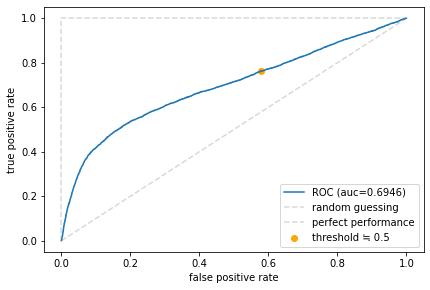

In [51]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.8,4.5))
ax.plot(fpr, tpr, label=f'ROC (auc={auc_val})')
ax.plot([0,1], [0,1], color='gray', linestyle='--',
        alpha=0.3, label='random guessing')
ax.plot([0,0,1], [0,1,1], color='gray', linestyle='--',
        alpha=0.3, label='perfect performance')
ax.scatter(fpr[6000], tpr[6000], color='orange', label='threshold ≒ 0.5')
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
plt.show()

In [52]:
cm

array([[ 9953, 13411],
       [ 1598,  5038]])

In [53]:
tn_05, fp_05, fn_05, tp_05 = cm.ravel()
fpr_05 = fp_05 / (fp_05 + tn_05)
tpr_05 = tp_05 / (tp_05 + fn_05)
acc_05 = (tp_05 + tn_05) / (tp_05 + tn_05 + fp_05 + fn_05)
print('fpr (threshold≒0.5):', fpr_05)
print('tpr (threshold≒0.5):', tpr_05)
print('accuracy (threshold≒0.5):', acc_05)

fpr (threshold≒0.5): 0.5740027392569765
tpr (threshold≒0.5): 0.7591922845087402
accuracy (threshold≒0.5): 0.4997
